# L3 Latencies, accesses by Core 0, Frequencies of Core 0 and 1 altered, Conway, I/O-Die in p-state P0

## Load necessary depencencies

In [2]:
import numpy
import csv
import re
import os
import matplotlib.pyplot as plt
import matplotlib

## Define functions

In [3]:
# taken from https://github.com/kloopuk/log-progress

# MIT License
#
# Copyright (c) 2016 bureaucratic-labs
# 
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [4]:
# generate lists of files with files according to search parameters
def listgenerator (filelist, startstring, searchpara, retlist):

    searchpara = searchpara + "\""
    
    for file in filelist:
        for line in open(file):
            if line.startswith(startstring):
                if searchpara in line:
                    retlist.append(file)

In [5]:
def evaluation(filelist, size, freq0, freq1, timeswitch):
    
    csvvalues = numpy.array([])
    datapoints = numpy.array([])
    evaluation_vals = numpy.array([])


    # use measurements for same core from run with core 1
    coreline = "BENCHIT_KERNEL_CPU_LIST=\"0\""

    core_found = False
    data_found = False


    # iterate over lines in file
    for file in filelist:

        # empty arrays
        csvvalues = numpy.array([])
        datapoints = numpy.array([])

        core_found = False
        data_found = False

        for line in open(file):
            if line.startswith('comment='):
                if not line.startswith('comment=\"Core0 at ' + freq0 + 'MHz, Core1 at ' + freq1 + 'MHz\"'):
                    break
                
            # check if file has data for core
            if line.startswith(coreline):
                core_found = True

            # data begins after "beginofdata" string, only search for this when coreline has been found in file
            if line.startswith("beginofdata") and core_found == True:
                data_found = True

            # append data to values array, make sure that no strings are appended
            if data_found == True and not line.startswith("endofdata") and not line.startswith("beginofdata"):
                
                # data for core 0 is taken from file that contains data for cores 0,1
                # data for core 0 can be found in col. index 1, every other core in col. index 2
                csvvalues = numpy.append(csvvalues, float(line.split()[int(2)]))

                # append data sizes
                datapoints = numpy.append(datapoints, str(line.split()[0]))

        # process data only when wanted data has been found in file
        if data_found == True:

            # find data size string in datapoints array
            index = numpy.where(datapoints == size)
            
            # save latency value for given data size and next 4 values to array
            if timeswitch:
                for i in range(4):
                    evaluation_vals = numpy.append(evaluation_vals, csvvalues[index[0] + i] )
            else:
                for i in range(4):
                    evaluation_vals = numpy.append(evaluation_vals, 
                                                  ( csvvalues[index[0] + i] * (float(freq0)/1000) ) )

    # calculate average
    # save min and max value as error
    average = numpy.average(evaluation_vals)
    minima = numpy.min(evaluation_vals)
    #average = numpy.average(evaluation_vals)
    stdev = numpy.std(evaluation_vals)

    return(average, stdev, minima)

In [21]:
# plotter function
def plotter(averages, Core0Frequencies, Core1Frequencies, baseFreqs, unit, machine):

    # print values on top of bars
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 5+height,
                    '%d' % round(height),
                rotation=90, ha='center', va='bottom', size='xx-small')

    fig, ax = plt.subplots()
    im = ax.imshow(averages, cmap='coolwarm')
    
    # set title according to memory level, CPU architecture, machine designation
    #ax.set_title('L3 Latencies in [' + unit + '],\non ' + machine + '\n', fontweight='bold', fontsize='xx-large')
    
    xlabels = numpy.array(len(baseFreqs) * Core0Frequencies)
    ylabels = numpy.array(Core1Frequencies)
    #ylabels = numpy.flipud(numpy.array(Core1Frequencies))
   
    # as many x-ticks as memory locations
    x = numpy.arange(len(xlabels))
    y = numpy.arange(len(ylabels))
    
    ax.set_xlabel('Frequency of Reading Core [MHz]', fontsize='x-large')
    ax.set_ylabel('Frequency of Remaining\nCores [MHz]', fontsize='x-large')

    # use instructions as xticks
    ax.set_xticks(x)
    ax.set_yticks(y)
    ax.set_xticklabels(xlabels, rotation=0, ha='center', rotation_mode='anchor', size='x-large') 
    ax.set_yticklabels(ylabels, rotation=0, ha='right', rotation_mode='anchor', size='x-large') #size='x-small',
    
    # create colorbar
    cbarlabel = "Latency [" + unit + "]"
    
    # define cbarticks that are evenly spread across value range and include min and max values
    steps = 4
    
    cbarticks = []

    cbarticks.append(round(averages.min()+0.05,1))
    cbarticks.append(round(averages.max()-0.05,1))
    
    for i in range(1,steps):
        cbarticks.append(round(averages.min() + ((averages.max()-averages.min()) * float(i)/steps),1))
    
    cbar = ax.figure.colorbar(im, shrink=1, pad=0.01, ticks=cbarticks)
    cbar.ax.set_ylabel(cbarlabel, rotation=+90, va="top", fontsize='x-large')
    cbar.ax.set_yticklabels(cbarticks, size='x-large')
    
    # secondary y-axis
    def cyctons(x):
        return (x-1) * len(Core0Frequencies)
    
    def nstocyc(x):
        return (x-1)/len(Core0Frequencies)
    
    # set color for font depending on value
    thresholdLower = im.norm(averages.max())/5.4
    thresholdUpper = im.norm(averages.max())/1.2
   
    textcolors=("white", "black")
    
    # secondary x-axis
    #secax = ax.secondary_xaxis('top', functions =(nstocyc, cyctons)) 
    #secax.set_xticks(numpy.arange(len(baseFreqs), step=1))
    #secax.set_xticklabels(baseFreqs)
    #secax.set_xlabel('Frequency of remaining Cores', fontsize='large')
    
    lc = 'white'
    lw = 3
    #ax.axvline(x=2.5, color=lc, linewidth=lw)
    #ax.axvline(x=5.5, color=lc, linewidth=lw)
    
    # Loop over data dimensions and create text annotations.
    for j in range(len(xlabels)):
        for i in range(len(ylabels)):
            if averages[i, j] > 100:
                value = round(averages[i, j])
            else:
                value = round(averages[i, j], 1)

            text = ax.text(j, i, value,
                           ha="center", va="center", size='large',
                           color=textcolors[int(im.norm(averages[i, j]) > 
                                                thresholdLower and im.norm(averages[i, j]) < 
                                                thresholdUpper)]) 
    
    # ensure that xticks-labels are being shown on saved plot
    fig.tight_layout()
        
    # save plot to file
    filename = machine + '-' + unit + '-L3-latencies-io_P0-L3_64B_aligned-reduced.pdf'
    
    matplotlib.pyplot.savefig(filename, dpi=300, format='pdf') 
    print(filename + ' has been saved to disk.')


## Create file lists

In [7]:
# get list of all files in directory
paths = ['datafiles-base_1500MHz', 'datafiles-base_2200MHz', 'datafiles-base_2500MHz' ]

filelist = [],[],[]

for path in log_progress(paths):
    index = paths.index(path)
    
    for entry in os.scandir(path): 
        filelist[index].append(entry.path)


In [8]:
files = [],[],[] # 0 = M, 1 = (E|U), 2 = S, 3 = E, 4 = I
state = 'M'

for path in log_progress(paths):
    index = paths.index(path)
    listgenerator(filelist[index], 'BENCHIT_KERNEL_USE_MODE', state, files[index])

    print("Files in list for state " + str(state) + ": " + str(len(files[index])))

Files in list for state M: 90
Files in list for state M: 90
Files in list for state M: 90


## Process data

In [9]:
size = '3.26407e+06'

Core0Frequencies = ['1500', '2200', '2500']
#Core1Frequencies = ['1500', '2200', '2500']
Core1Frequencies = ['2500', '2200', '1500']
baseFreqs = ['1500']
#baseFreqs = ['2500', '2200', '2500']


# arrays for results in [ns]
averages = numpy.zeros([len(Core0Frequencies), len(Core1Frequencies) * len(baseFreqs)]) # States, Datasizes, Core 1, Core 2
stdev = numpy.zeros([len(Core0Frequencies), len(Core1Frequencies) * len(baseFreqs)])
minima = numpy.zeros([len(Core0Frequencies), len(Core1Frequencies) * len(baseFreqs)])

# arrays for results in [cycles]
averagesCycles = numpy.zeros([len(Core0Frequencies), len(Core1Frequencies) * len(baseFreqs)]) # States, Datasizes, Core 1, Core 2
stdevCycles = numpy.zeros([len(Core0Frequencies), len(Core1Frequencies) * len(baseFreqs)])

for baseFreq in log_progress(baseFreqs):
    baseFreq_index = baseFreqs.index(baseFreq)
    
    for Core0Freq in Core0Frequencies:
        Core0Freq_index = Core0Frequencies.index(Core0Freq)

        for Core1Freq in Core1Frequencies:
            Core1Freq_index = Core1Frequencies.index(Core1Freq)
             
            averages[Core1Freq_index][baseFreq_index * len(Core1Frequencies) + Core0Freq_index], \
            stdev[Core1Freq_index][baseFreq_index * len(Core1Frequencies) + Core0Freq_index], \
            minima[Core1Freq_index][baseFreq_index * len(Core1Frequencies) + Core0Freq_index] = \
            evaluation(files[baseFreq_index], size, Core0Freq, Core1Freq, 1)

            averagesCycles[Core1Freq_index][baseFreq_index * len(Core1Frequencies) + Core0Freq_index], \
            stdevCycles[Core1Freq_index][baseFreq_index * len(Core1Frequencies) + Core0Freq_index], _ = \
            evaluation(files[baseFreq_index], size, Core0Freq, Core1Freq, 0)


## Plot Data

AMD EPYC 7502-ns-L3-latencies-io_P0-L3_64B_aligned-reduced.pdf has been saved to disk.
AMD EPYC 7502-Cycles-L3-latencies-io_P0-L3_64B_aligned-reduced.pdf has been saved to disk.


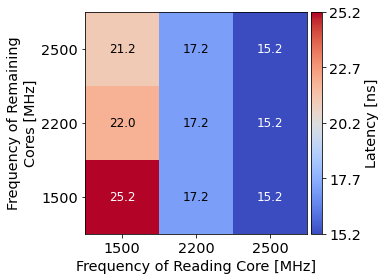

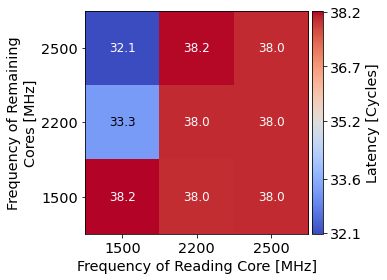

In [22]:
plotter(minima, Core0Frequencies, Core1Frequencies, baseFreqs, 'ns',
            'AMD EPYC 7502')
plotter(averagesCycles, Core0Frequencies, Core1Frequencies, baseFreqs, 'Cycles',
            'AMD EPYC 7502')